In [43]:
import os
import sys

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils
from utils import metrics as mtc

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [86]:
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity


# Готовим дата-сеты с регионом

In [45]:
reference = pd.read_csv("../../data/preprocessed/exp23/reference.csv")
train = pd.read_csv("../../data/preprocessed/exp23/train.csv")
valid = pd.read_csv("../../data/preprocessed/exp23/valid.csv")

In [46]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      305 non-null    int64 
 1   region  305 non-null    object
 2   exp5    305 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.3+ KB


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   exp5       548 non-null    object
 1   school_id  550 non-null    int64 
 2   region     428 non-null    object
dtypes: int64(1), object(2)
memory usage: 13.0+ KB


In [48]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   exp5       184 non-null    object
 1   school_id  184 non-null    int64 
 2   region     140 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.4+ KB


In [49]:
reference.head()

,id,region,exp5
0,69,мурманская область,кировска
1,70,московская область,клин спортивный
2,71,калининградская область,спортивная школа псковской области зимние виды...
3,8,свердловская область,айсберг
4,73,челябинская область,команда дмитриева


In [50]:
valid.head()

,exp5,school_id,region
0,спортивная школа олимпийского резерва,198,санкт петербург
1,мауо спортивная школа 11,184,липецкая область
2,лига фигурного катания,293,москва
3,клуб фигурного катания динамо,277,санкт петербург
4,мбау всеволжская спортивная школа олимпийского...,35,ленинградская область


In [64]:
merged_train = pd.read_csv("../../data/preprocessed/exp23/merged_train.csv")
merged_train = merged_train[~merged_train.exp5.isna()]
merged_valid = pd.read_csv("../../data/preprocessed/exp23/merged_valid.csv")
merged_valid = merged_valid[~merged_valid.exp5.isna()]


### Преобразования в np.array

In [52]:
x_train = train["exp5"].to_numpy(dtype="str").flatten()
y_train = train["school_id"].to_numpy(dtype="int").flatten()
region_train = train["region"].to_numpy(dtype="str").flatten()

x_valid = valid["exp5"].to_numpy(dtype="str").flatten()
y_valid = valid["school_id"].to_numpy(dtype="int").flatten()
region_valid = valid["region"].to_numpy(dtype="str").flatten()

reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["exp5"].to_numpy(dtype="str").flatten()
reference_region = reference["region"].to_numpy(dtype="str").flatten()

# Построение модели

In [65]:
merged_train["target"] = 1

In [66]:
merged_train.head()

,exp5,exp5_reference,target
0,московская академия фигурного катания на коньк...,мечта,1
1,спортивная школа космос,космос,1
2,7 округ династия,династия,1
3,спортивный клуб фигурного катания спартак,спартак,1
4,дмитриев,команда дмитриева,1


In [212]:
temp_df = merged_train.copy()
train_classif = merged_train.copy()

for i in range(0, 5, 1):
    temp_df = temp_df.copy()

    # Параметр для сдвига
    shift_amount = 15  # Положительное значение сдвигает вниз, отрицательное - вверх

    # Сдвиг второго столбца
    temp_df["exp5_reference"] = temp_df["exp5_reference"].shift(shift_amount)
    temp_df["target"] = 0

    # Новый датафрейм с исходным и сдвинутым столбцами
    temp_df = temp_df.dropna()

    train_classif = pd.concat([train_classif, temp_df])

train_classif.reset_index(drop=True, inplace=True)


In [213]:
train_classif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3063 entries, 0 to 3062
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   exp5            3063 non-null   object
 1   exp5_reference  3063 non-null   object
 2   target          3063 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 71.9+ KB


In [214]:
train_classif[train_classif.target == 0]

,exp5,exp5_reference,target
548,спорт индустрия великий новгород,мечта,0
549,темпо,космос,0
550,московская академия фигурного катания на коньк...,династия,0
551,спортивная школа айсберг,спартак,0
552,московская академия фигурного катания на коньк...,команда дмитриева,0
...,...,...,...
3058,московская академия фигурного катания на коньк...,брянск,0
3059,спортивная школа космос,спортивный клуб фигурного катания москвиной,0
3060,московская академия фигурного катания на коньк...,энергия льда,0
3061,спортивный клуб спортивно тренировочный центр ...,спортивная школа им александра козицына,0


In [215]:
# Объединение текстов для векторизации
train_classif["combined"] = (
    train_classif["exp5"] + " " + train_classif["exp5_reference"]
)

# Разделение на признаки и целевую переменную
X_meta = train_classif["combined"]
y_meta = train_classif["target"]


In [216]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки

X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(
    X_meta, y_meta, test_size=0.2, stratify=y_meta, random_state=42
)


# CATBOOST

In [551]:
# Создание пайплайна для векторизации, балансировки классов и обучения модели логистической регрессии
pipeline = ImbPipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("smote", SMOTE(sampling_strategy="auto", k_neighbors=5, random_state=42)),
        (
            "clf",
            CatBoostClassifier(
                iterations=1000, verbose=100, auto_class_weights="SqrtBalanced"
            ),
        ),
    ]
)


In [552]:
# Обучение модели
pipeline.fit(X_train_meta, y_train_meta)


Learning rate set to 0.018669
0:	learn: 0.6896496	total: 11.9ms	remaining: 11.9s
100:	learn: 0.5205198	total: 1.09s	remaining: 9.68s
200:	learn: 0.4479937	total: 2.03s	remaining: 8.06s
300:	learn: 0.4014274	total: 2.88s	remaining: 6.7s
400:	learn: 0.3628288	total: 3.73s	remaining: 5.58s
500:	learn: 0.3297231	total: 4.61s	remaining: 4.59s
600:	learn: 0.2954651	total: 5.57s	remaining: 3.69s
700:	learn: 0.2665631	total: 6.46s	remaining: 2.76s
800:	learn: 0.2448643	total: 7.35s	remaining: 1.83s
900:	learn: 0.2268492	total: 8.23s	remaining: 904ms
999:	learn: 0.2126225	total: 9.14s	remaining: 0us


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('smote', SMOTE(random_state=42)),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x0000027D37A5A060>)])

In [553]:
# Оценка модели
y_pred_meta_train = pipeline.predict(X_test_meta)


In [554]:
print(classification_report(y_test_meta, y_pred_meta_train))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       503
           1       0.65      0.83      0.73       110

    accuracy                           0.89       613
   macro avg       0.81      0.87      0.83       613
weighted avg       0.91      0.89      0.90       613



In [561]:
valid_pos_classif = pd.DataFrame()

# Объединение текстов для векторизации
valid_pos_classif["left"] = merged_valid["exp5"]
valid_pos_classif["right"] = merged_valid["exp5_reference"]

valid_pos_classif["combined"] = (
    valid_pos_classif["left"] + " " + valid_pos_classif["right"]
)


In [562]:
# Оценка модели
y_pred_meta_valid_pos = pipeline.predict(valid_pos_classif["combined"])


In [563]:
sum(y_pred_meta_valid_pos) / len(y_pred_meta_valid_pos)

0.9395604395604396

In [564]:
valid_neg_classif = pd.DataFrame()

# Объединение текстов для векторизации
valid_neg_classif["left"] = merged_valid["exp5"]
valid_neg_classif["right"] = merged_valid["exp5_reference"].shift(5)

valid_neg_classif["combined"] = (
    valid_neg_classif["left"] + " " + valid_neg_classif["right"]
)

valid_neg_classif = valid_neg_classif[~valid_neg_classif.combined.isna()]


In [565]:
# Оценка модели
y_pred_meta_valid_neg = pipeline.predict(valid_neg_classif["combined"])


In [566]:
sum(y_pred_meta_valid_neg) / len(y_pred_meta_valid_neg)

0.1694915254237288

In [567]:
ids = np.where(y_pred_meta_valid_pos == 0)[0]
ids.tolist()


[10, 38, 42, 53, 76, 104, 123, 144, 163, 167, 181]

In [569]:
valid_pos_classif.loc[ids.tolist(), :]

,left,right,combined
10,72 округ центр физической культуры спорта и зд...,центр физической культуры спорта и здоровья фр...,72 округ центр физической культуры спорта и зд...
38,вро всероссийское физкультурно-спортивное обще...,динамо,вро всероссийское физкультурно-спортивное обще...
42,республика республики саха спортивная школа пс...,республики саха якутия спортивная школа псковс...,республика республики саха спортивная школа пс...
53,вро всероссийское физкультурно-спортивное обще...,динамо,вро всероссийское физкультурно-спортивное обще...
76,спортивная школа стрела,стрела,спортивная школа стрела стрела
104,спортивная школа олимпийского резерва псковско...,спортивная школа олимпийского резерва псковско...,спортивная школа олимпийского резерва псковско...
123,московская академия фигурного катания на коньк...,хрустальный,московская академия фигурного катания на коньк...
144,ярославль спортивная школа олимпийского резерва 4,спортивная школа олимпийского резерва 4,ярославль спортивная школа олимпийского резерв...
163,спортивная школа олимпийского резерва орленок ...,орленок,спортивная школа олимпийского резерва орленок ...
167,спортивный,клин спортивный,спортивный клин спортивный


In [570]:
ids = np.where(y_pred_meta_valid_pos == 1)[0][:10]
ids.tolist()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [571]:
valid_pos_classif.loc[ids.tolist(), :]

,left,right,combined
0,спортивная школа олимпийского резерва,спортивная школа олимпийского резерва академия...,спортивная школа олимпийского резерва спортивн...
1,мауо спортивная школа 11,спортивная школа 11,мауо спортивная школа 11 спортивная школа 11
2,лига фигурного катания,лига фигурного катания,лига фигурного катания лига фигурного катания
3,клуб фигурного катания динамо,клуб фигурного катания динамо,клуб фигурного катания динамо клуб фигурного к...
4,мбау всеволжская спортивная школа олимпийского...,всеволжская спортивная школа олимпийского резерва,мбау всеволжская спортивная школа олимпийского...
5,клуб фигурного катания герасимовой,клуб фигурного катания герасимовой,клуб фигурного катания герасимовой клуб фигурн...
6,академия фигурного катания наши надежды,наши надежды,академия фигурного катания наши надежды наши н...
7,спортивная школа академия фигурного катания на...,академия фигурного катания на коньках,спортивная школа академия фигурного катания на...
8,спортивная школа олимпийского резерва орленок,орленок,спортивная школа олимпийского резерва орленок ...
9,физкультурно спортивное объединение школа фигу...,бриллиантовый лед,физкультурно спортивное объединение школа фигу...


## Подбор параметров

In [501]:
param_dist = {
    "clf__iterations": np.arange(100, 1001, 100),
    "clf__depth": np.arange(3, 11, 1),
    "clf__learning_rate": np.logspace(-3, 0, 10),
    "clf__l2_leaf_reg": np.logspace(-3, 2, 10),
    "clf__border_count": np.arange(1, 256, 1),
}


In [503]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=25,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)


In [504]:
# Выполняем поиск по гиперпараметрам
rs.fit(X_train_meta, y_train_meta)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
0:	learn: 0.6862286	total: 6.87ms	remaining: 3.43s
100:	learn: 0.4375747	total: 659ms	remaining: 2.6s
200:	learn: 0.3380908	total: 1.33s	remaining: 1.98s
300:	learn: 0.2579854	total: 1.95s	remaining: 1.29s
400:	learn: 0.2074752	total: 2.55s	remaining: 629ms
499:	learn: 0.1734824	total: 3.17s	remaining: 0us


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('clf',
                                              <catboost.core.CatBoostClassifier object at 0x0000027D37A5A780>)]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'clf__border_count': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  3...
                                        'clf__iterations': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'clf__l2_leaf_reg': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                                        'clf__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])},
                   random_state=42, scoring='f1', verbose=1)

In [510]:
# Оценка модели
y_pred_meta_train_rs = rs.predict(X_test_meta)


In [511]:
print(classification_report(y_test_meta, y_pred_meta_train_rs))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       503
           1       0.65      0.83      0.73       110

    accuracy                           0.89       613
   macro avg       0.81      0.87      0.83       613
weighted avg       0.91      0.89      0.90       613



In [512]:
# Оценка модели
y_pred_meta_valid_pos_rs = rs.predict(valid_pos_classif["combined"])
y_pred_meta_valid_neg_rs = rs.predict(valid_neg_classif["combined"])


In [513]:
sum(y_pred_meta_valid_pos_rs) / len(y_pred_meta_valid_pos_rs)

0.9505494505494505

In [514]:
sum(y_pred_meta_valid_neg_rs) / len(y_pred_meta_valid_neg_rs)

0.15254237288135594

# XGBoost

In [379]:
from xgboost import XGBClassifier

# Создание пайплайна для векторизации, балансировки классов и обучения модели логистической регрессии
pipeline = ImbPipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("smote", SMOTE(random_state=42)),
        ("clf", XGBClassifier(eval_metric="logloss")),
    ]
)


In [380]:
# Обучение модели
pipeline.fit(X_train_meta, y_train_meta)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('smote', SMOTE(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [381]:
# Оценка модели
y_pred_meta_train = pipeline.predict(X_test_meta)


In [382]:
print(classification_report(y_test_meta, y_pred_meta_train))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       503
           1       0.65      0.86      0.74       110

    accuracy                           0.89       613
   macro avg       0.81      0.88      0.84       613
weighted avg       0.91      0.89      0.90       613



In [383]:
valid_pos_classif = pd.DataFrame()

# Объединение текстов для векторизации
valid_pos_classif["combined"] = (
    merged_valid["exp5"] + " " + merged_valid["exp5_reference"]
)


In [384]:
# Оценка модели
y_pred_meta_valid_pos = pipeline.predict(valid_pos_classif["combined"])


In [385]:
sum(y_pred_meta_valid_pos) / len(y_pred_meta_valid_pos)

0.9230769230769231

In [386]:
valid_neg_classif = pd.DataFrame()

# Объединение текстов для векторизации
valid_neg_classif["combined"] = (
    merged_valid["exp5"] + " " + merged_valid["exp5_reference"].shift(5)
)

valid_neg_classif = valid_neg_classif[~valid_neg_classif.combined.isna()]


In [387]:
# Оценка модели
y_pred_meta_valid_neg = pipeline.predict(valid_neg_classif["combined"])


In [388]:
sum(y_pred_meta_valid_neg) / len(y_pred_meta_valid_neg)

0.1694915254237288

## Подбор параметров

In [395]:
param_dist = {
    "clf__n_estimators": np.arange(100, 1001, 100),
    "clf__max_depth": np.arange(3, 11, 1),
    "clf__learning_rate": np.logspace(-3, 0, 10),
    "clf__subsample": np.linspace(0.5, 1.0, 6),
    "clf__colsample_bytree": np.linspace(0.5, 1.0, 6),
    "clf__gamma": np.logspace(-3, 1, 5),
}


In [403]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1",
    cv=3,
    verbose=100,
    n_jobs=-1,
    random_state=42,
)


In [404]:
# Выполняем поиск по гиперпараметрам
rs.fit(X_train_meta, y_train_meta)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('smote', SMOTE(random_state=42)),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',
                                                            feature_types=None,
                                                            ga...
                                        'clf__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                                        'clf__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'clf__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                                        'clf__n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'clf__subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='accuracy', verbose=1)

In [405]:
# Оценка модели
y_pred_meta_train_rs = rs.predict(X_test_meta)


In [406]:
print(classification_report(y_test_meta, y_pred_meta_train_rs))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       503
           1       0.65      0.85      0.74       110

    accuracy                           0.89       613
   macro avg       0.81      0.88      0.83       613
weighted avg       0.91      0.89      0.90       613



In [407]:
# Оценка модели
y_pred_meta_valid_pos_rs = rs.predict(valid_pos_classif["combined"])
y_pred_meta_valid_neg_rs = rs.predict(valid_neg_classif["combined"])


In [408]:
sum(y_pred_meta_valid_pos_rs) / len(y_pred_meta_valid_pos_rs)

0.9175824175824175

In [409]:
sum(y_pred_meta_valid_neg_rs) / len(y_pred_meta_valid_neg_rs)

0.15819209039548024

# SVM

In [452]:
from sklearn.svm import SVC

# Создание пайплайна для векторизации, балансировки классов и обучения модели логистической регрессии
pipeline = ImbPipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("smote", SMOTE(sampling_strategy=0.5, k_neighbors=2, random_state=42)),
        # ("clf", SVC(kernel='poly')),
        ("clf", SVC(kernel="rbf")),
    ]
)


In [453]:
# Обучение модели
pipeline.fit(X_train_meta, y_train_meta)


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('smote',
                 SMOTE(k_neighbors=2, random_state=42, sampling_strategy=0.5)),
                ('clf', SVC())])

In [454]:
# Оценка модели
y_pred_meta_train = pipeline.predict(X_test_meta)


In [455]:
print(classification_report(y_test_meta, y_pred_meta_train))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       503
           1       0.73      0.34      0.46       110

    accuracy                           0.86       613
   macro avg       0.80      0.65      0.69       613
weighted avg       0.84      0.86      0.84       613



In [456]:
valid_pos_classif = pd.DataFrame()

# Объединение текстов для векторизации
valid_pos_classif["combined"] = (
    merged_valid["exp5"] + " " + merged_valid["exp5_reference"]
)


In [457]:
# Оценка модели
y_pred_meta_valid_pos = pipeline.predict(valid_pos_classif["combined"])


In [458]:
sum(y_pred_meta_valid_pos) / len(y_pred_meta_valid_pos)

0.4835164835164835

In [459]:
valid_neg_classif = pd.DataFrame()

# Объединение текстов для векторизации
valid_neg_classif["combined"] = (
    merged_valid["exp5"] + " " + merged_valid["exp5_reference"].shift(5)
)

valid_neg_classif = valid_neg_classif[~valid_neg_classif.combined.isna()]


In [460]:
# Оценка модели
y_pred_meta_valid_neg = pipeline.predict(valid_neg_classif["combined"])


In [461]:
sum(y_pred_meta_valid_neg) / len(y_pred_meta_valid_neg)

0.05084745762711865

## Подбор параметров

In [462]:
param_dist = {
    "clf__C": np.logspace(-3, 2, 10),
    "clf__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "clf__gamma": ["scale", "auto"] + list(np.logspace(-3, 2, 10)),
}


In [463]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)


In [464]:
# Выполняем поиск по гиперпараметрам
rs.fit(X_train_meta, y_train_meta)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('smote',
                                              SMOTE(k_neighbors=2,
                                                    random_state=42,
                                                    sampling_strategy=0.5)),
                                             ('clf', SVC())]),
                   n_jobs=-1,
                   param_distributions={'clf__C': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                                        'clf__gamma': ['scale', 'auto', 0.001,
                                                       0.003593813663804626,
                                                       0.01291549665014884,
                                                       0.046415888336127795,
                                                       0.1668100537200059,
                                                       0.5994842503189409,
                                                       2.1544346900318843,
                                                       7.742636826811277,
                                                       27.825594022071257,
                                                       100.0],
                                        'clf__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid']},
                   random_state=42, scoring='f1', verbose=1)

In [465]:
# Оценка модели
y_pred_meta_train_rs = rs.predict(X_test_meta)


In [466]:
print(classification_report(y_test_meta, y_pred_meta_train_rs))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       503
           1       0.65      0.78      0.71       110

    accuracy                           0.89       613
   macro avg       0.80      0.85      0.82       613
weighted avg       0.90      0.89      0.89       613



In [467]:
# Оценка модели
y_pred_meta_valid_pos_rs = rs.predict(valid_pos_classif["combined"])
y_pred_meta_valid_neg_rs = rs.predict(valid_neg_classif["combined"])


In [468]:
sum(y_pred_meta_valid_pos_rs) / len(y_pred_meta_valid_pos_rs)

0.9340659340659341

In [469]:
sum(y_pred_meta_valid_neg_rs) / len(y_pred_meta_valid_neg_rs)

0.1638418079096045

In [77]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances


def calculate_similarity(x, y, method="cosine"):
    if method == "cosine":
        return cosine_similarity(x, y)
    elif method == "euclidean":
        return -euclidean_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    elif method == "manhattan":
        return -manhattan_distances(x, y)  # Инвертируем, чтобы максимизировать схожесть
    else:
        raise ValueError(f"Unknown similarity method: {method}")

In [78]:
def find_matches(
    x_vec,
    x_region,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=0.9,
    filter_by_region=True,
    empty_region="all",
    similarity_method="cosine",
):
    y_pred = []
    manual_review = []

    for i, x in enumerate(x_vec):
        # Фильтруем reference_vec и reference_id по текущему региону, если включена фильтрация по регионам
        if filter_by_region:
            # Фильтруем reference_vec и reference_id по текущему региону
            current_region = x_region[i]
            region_mask = reference_region == current_region
            filtered_reference_vec = reference_vec[region_mask]
            filtered_reference_id = reference_id[region_mask]

            # Способ обработки, если в текущем регионе нет школ для сравнения
            if empty_region == "all":
                # Если в текущем регионе нет школ для сравнения, используем все школы
                if filtered_reference_vec.shape[0] == 0:
                    filtered_reference_vec = reference_vec
                    filtered_reference_id = reference_id
            else:
                if filtered_reference_vec.shape[0] == 0:
                    # Если в текущем регионе нет школ для сравнения, то помечаем на ручную обработку
                    manual_review.append(x)
                    top_matches = [(None, 0.0)] * top_k
                    y_pred.append(top_matches)
                    continue
        else:
            filtered_reference_vec = reference_vec
            filtered_reference_id = reference_id

        # Вычисляем выбранное расстояние
        similarities = calculate_similarity(
            x, filtered_reference_vec, method=similarity_method
        ).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)

        # Учитываем пороговое значение для различных методов
        if similarity_method == "cosine":
            if max_similarity < threshold:
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        else:  # Для других методов расстояний (евклидово и манхэттенское)
            if max_similarity > -threshold:  # Обратите внимание на инверсию
                manual_review.append(x)
                top_matches = [(None, 0.0)] * top_k
            else:
                top_matches = [
                    (filtered_reference_id[i], -similarities[i]) for i in top_indices
                ]
                if len(top_matches) < top_k:
                    top_matches += [(None, 0.0)] * (top_k - len(top_matches))

        y_pred.append(top_matches)

    return y_pred, manual_review

# Использование модели

In [79]:
# Векторизация текстов
vectorizer = TfidfVectorizer().fit(np.append(x_train, reference_name))
x_vec_valid = vectorizer.transform(x_valid)
reference_vec = vectorizer.transform(reference_name)

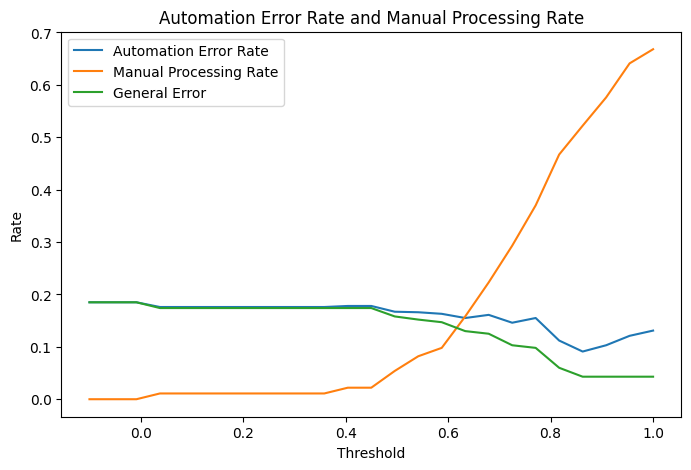

In [83]:
# Массив значений threshold
threshold_values = np.linspace(-0.1, 1.0, 25)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches(
        x_vec_valid,
        region_valid,
        reference_id,
        reference_vec,
        reference_region,
        top_k=5,
        threshold=threshold,
        filter_by_region=True,
        empty_region="all",
        # similarity_method="euclidean",
        similarity_method="cosine",
        # similarity_method="manhattan",
    )
    metrics = mtc.calculate_metrics(y_valid, y_pred, manual_review)
    metrics_list.append(metrics)

# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(threshold_values, auto_error_rate_values, label="Automation Error Rate")
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    label="Manual Processing Rate",
)
plt.plot(threshold_values, general_error_values, label="General Error")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Automation Error Rate and Manual Processing Rate")
plt.legend()

plt.show()

In [91]:
y_pred, manual_review = find_matches(
    x_vec_valid,
    region_valid,
    reference_id,
    reference_vec,
    reference_region,
    top_k=5,
    threshold=-1,
    filter_by_region=True,
    empty_region="all",  # is ignored if filter_by_region=False
    # similarity_method="euclidean",
    similarity_method="cosine",
    # similarity_method="manhattan",
)

metrics = mtc.calculate_metrics(y_valid, y_pred, manual_review)
metrics

{'Accuracy@1': 0.815,
 'Accuracy@3': 0.973,
 'Accuracy@5': 0.973,
 'auto_error_rate': 0.185,
 'manual_processing_rate': 0.0,
 'general_error': 0.185}